# Encode Analysis

## Imports

In [205]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import time
import multiprocessing
import sklearn
from sklearn import linear_model
import scipy
from sklearn import preprocessing
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Download

In [2]:
workingDirectory = '/home/jtao/analysis/encode_analysis/'
os.chdir(workingDirectory)

In [ ]:
%%bash
# data downloaded from:
# https://www.encodeproject.org/search/?type=Experiment&biosample_term_name=K562&assay_title=ChIP-seq&target.investigated_as=transcription+factor&files.file_type=bed+narrowPeak&limit=all&replication_type=isogenic&assembly=GRCh38
# K562 cells
# Encode 2 and 3
# hg38
# target of assay: transcription factor
# bed narrowPeak
# isogenic replicates
# files .txt downloaed from encodeproject.org interface
xargs -n 1 curl -O -L < files.txt

In [81]:
! mkdir ./download
!mv ./*gz ./download/

In [3]:
metadata_frame = pd.read_csv('./metadata.tsv', sep='\t')

In [4]:
targets = sorted(set(metadata_frame['Experiment target'].values))

untagged_targets = [x for x in targets if not 'GFP' in x]

In [5]:
# get rows specifying:
# optimal idr threshold peaks
# untagged protein targets
# aligned to hg38
# K562 cell line
# no audit issues
filtered_metadata_frame = metadata_frame[(metadata_frame['Output type'] == 'optimal idr thresholded peaks') &
                                         (metadata_frame['Experiment target'].isin(untagged_targets)) &
                                         (metadata_frame['Assembly'] == 'GRCh38') &
                                         (metadata_frame['Biosample term name'] == 'K562') &
                                         (metadata_frame['Audit NOT_COMPLIANT'].astype(str) == 'nan')
                                         ]

In [121]:
# copy idr peaks to different directory
if not os.path.isdir('./idr_peaks/'):
    os.mkdir('./idr_peaks/')
for target in untagged_targets:
    counter = 1
    file_accessions = filtered_metadata_frame[filtered_metadata_frame['Experiment target'] == target]['File accession'].values
    for fa in file_accessions:
        os.system('cp ./download/' + fa + '.bed.gz ./idr_peaks/' + target + '_'+str(counter)+ '_' + fa + '.bed.gz')
        counter +=1

In [122]:
# unzip idr peaks
! gzip -d ./idr_peaks/*

## Resize peaks

chrom - Name of the chromosome (or contig, scaffold, etc.).

chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.

chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature. For example, the first 100 bases of a chromosome are defined as chromStart=0, chromEnd=100, and span the bases numbered 0-99.

name - Name given to a region (preferably unique). Use "." if no name is assigned.

score - Indicates how dark the peak will be displayed in the browser (0-1000). If all scores were "'0"' when the data were submitted to the DCC, the DCC assigned scores 1-1000 based on signal value. Ideally the average signalValue per base spread is between 100-1000.

strand - +/- to denote strand or orientation (whenever applicable). Use "." if no orientation is assigned.

signalValue - Measurement of overall (usually, average) enrichment for the region.

pValue - Measurement of statistical significance (-log10). Use -1 if no pValue is assigned.

qValue - Measurement of statistical significance using false discovery rate (-log10). Use -1 if no qValue is assigned.

peak - Point-source called for this peak; 0-based offset from chromStart. Use -1 if no point-source called.

In [ ]:
# for plotting size distributions
size_list = []
factor_list = []

# for new metadata frame
accessions = []
factors = []
mean_sizes = []
numPeaks = []
file_names = []
for peak_file in os.listdir('./idr_peaks'):
    peak_frame = pd.read_csv('./idr_peaks/' + peak_file, sep='\t', names = ['chrom',
                                                                             'chromStart',
                                                                             'chromEnd',
                                                                             'name',
                                                                             'score',
                                                                             'strand',
                                                                             'signalValue',
                                                                             'pValue',
                                                                             'qValue',
                                                                             'peak'])
    sizes = list((peak_frame['chromEnd'] - peak_frame['chromStart']).values)
    factor = peak_file.split('_')[0].replace('-human','')
    accession = peak_file.split('_')[1].replace('.bed','')
    
    factor_list = factor_list + [factor] * len(sizes)
    size_list = size_list + sizes
    
    accessions.append(accession)
    factors.append(factor)
    numPeaks.append(peak_frame.shape[0])
    mean_sizes.append(np.mean(sizes))
    file_names.append(peak_file)
    
    
    print(factor, np.mean(sizes))



In [7]:
peakSize_frame = pd.DataFrame({'Factor':factor_list,
                               'Peak Size':size_list},
                              )


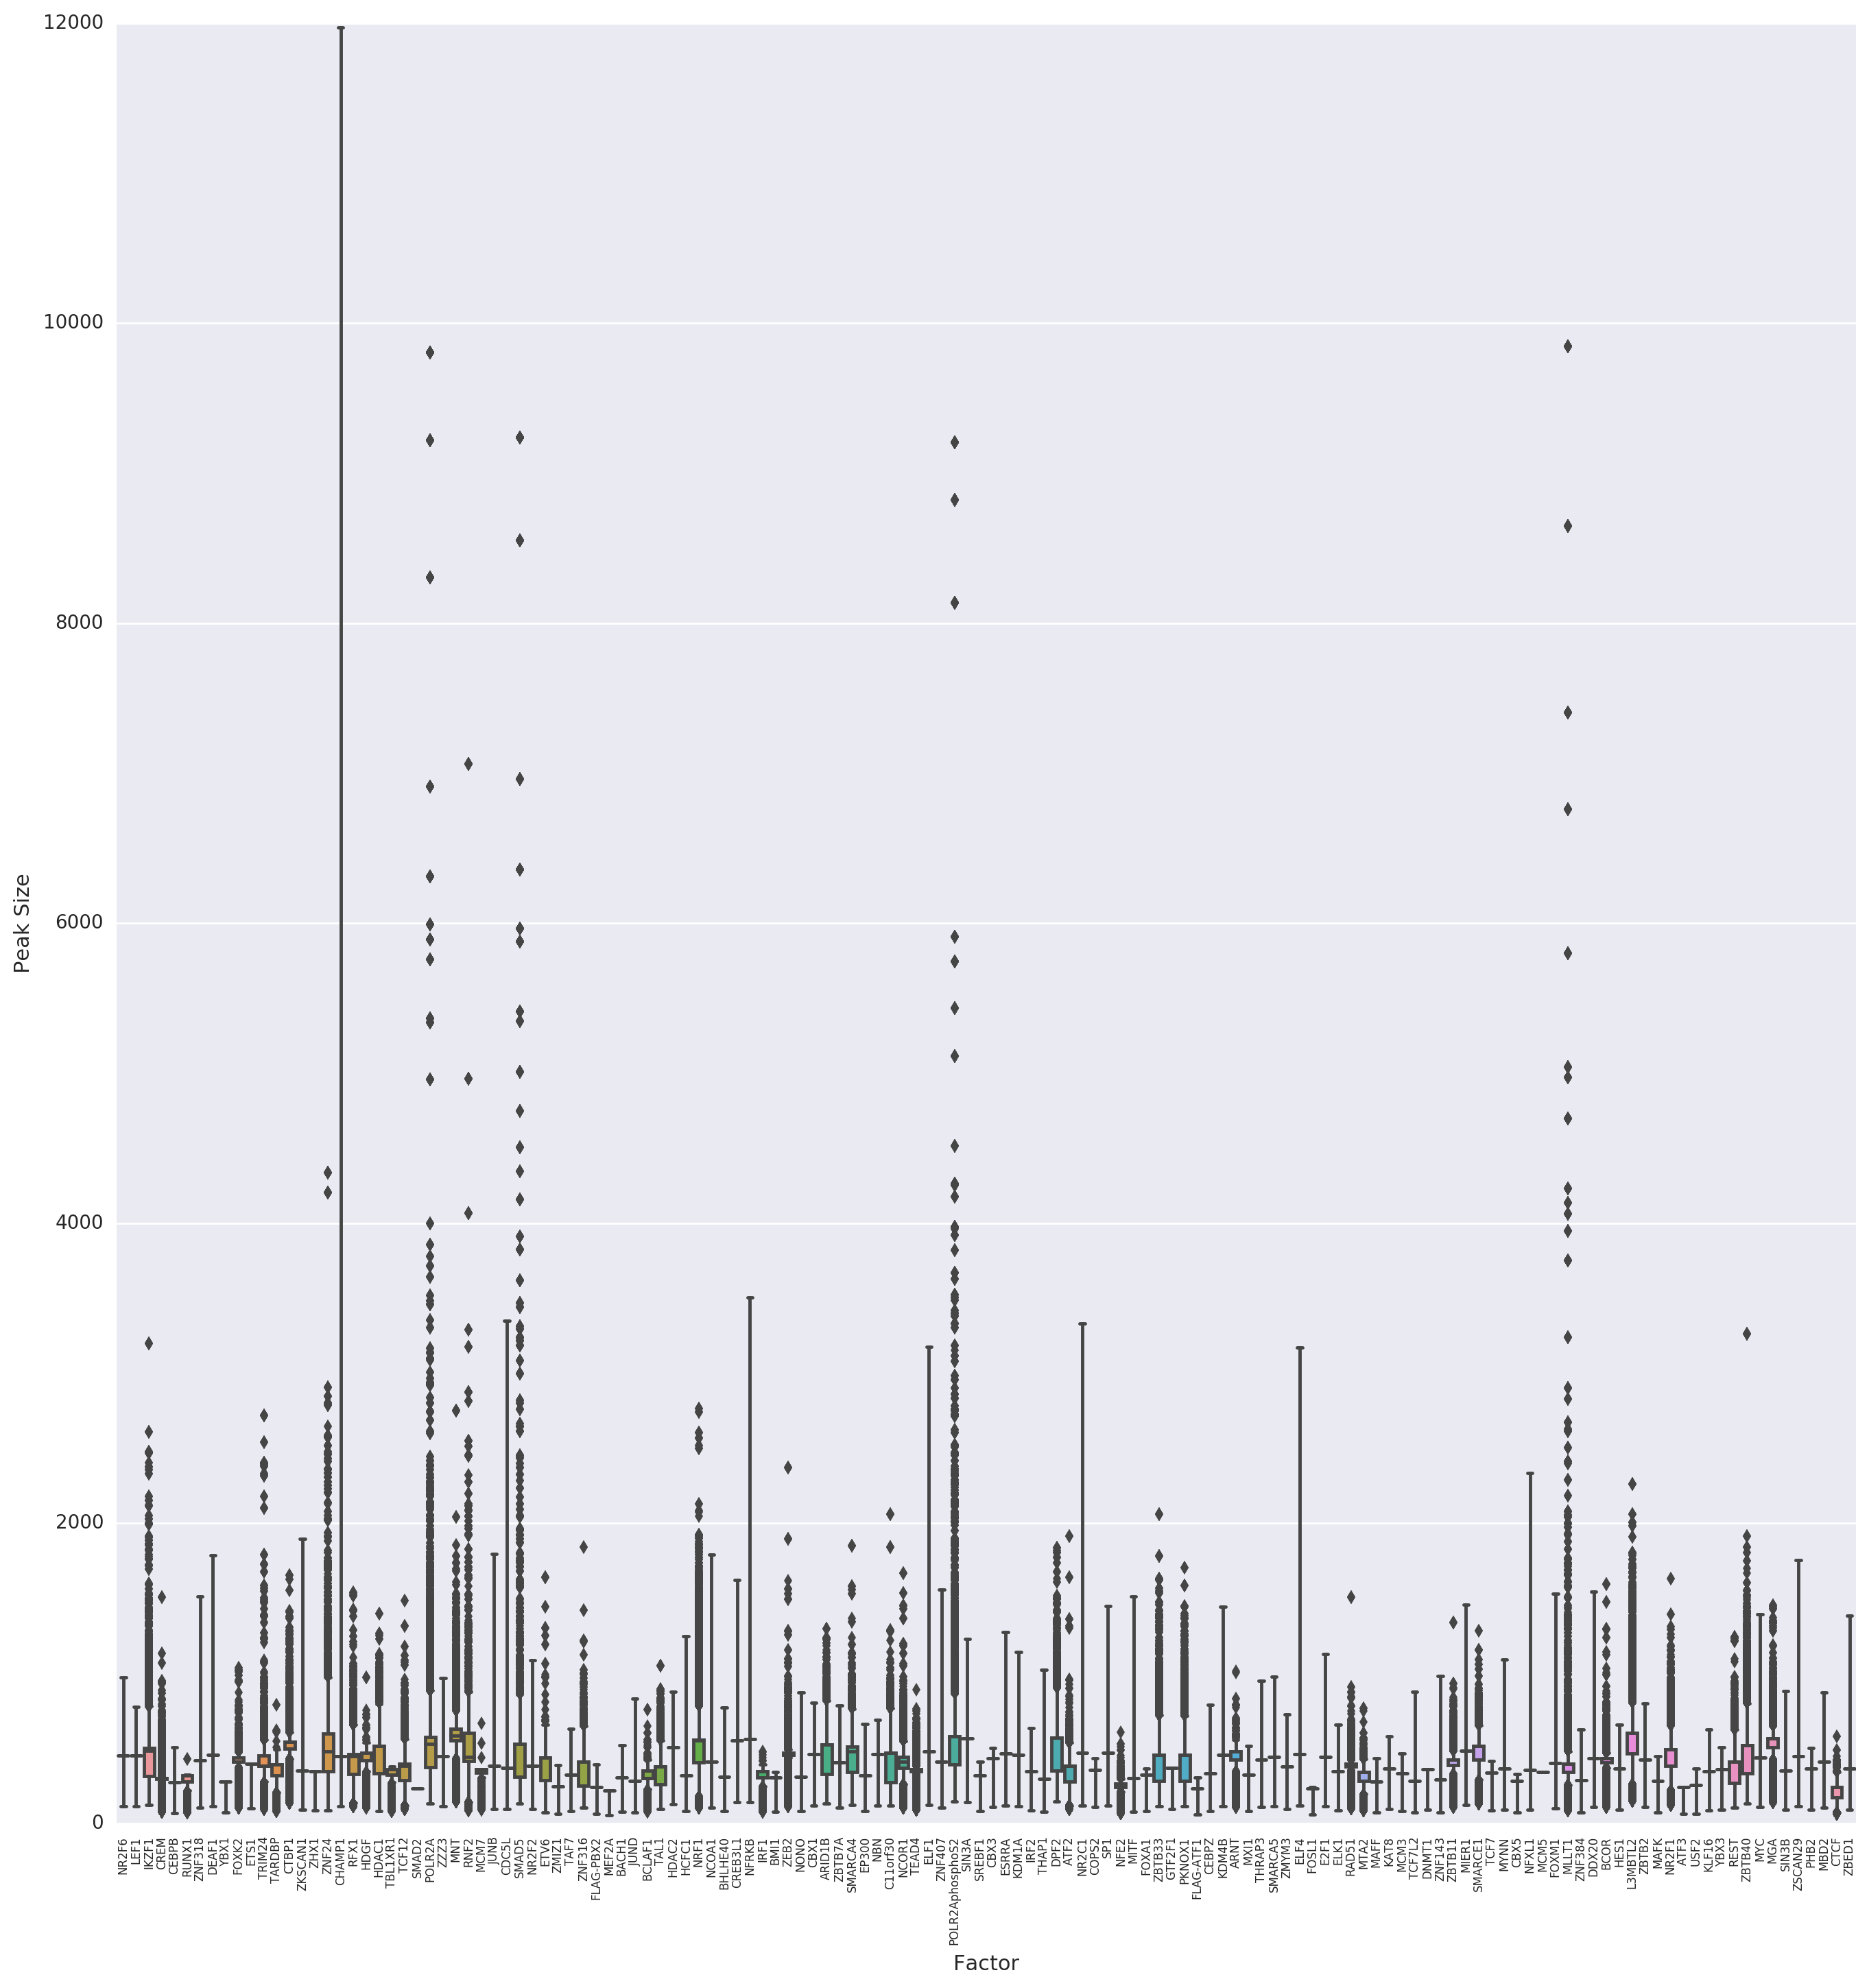

In [8]:
sns.factorplot(data = peakSize_frame, x = 'Factor', y= 'Peak Size', size=14, kind='box')
plt.xticks(rotation = 90, size=6);

In [9]:
metadata_frame = pd.DataFrame({'Factor':factors,
                               'Accession':accessions,
                               'Num Peaks':numPeaks,
                               'Mean Peak Size': mean_sizes,
                               'File Name': file_names})

In [10]:
filtered_metadata_frame = metadata_frame[metadata_frame['Num Peaks'] > 1000]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


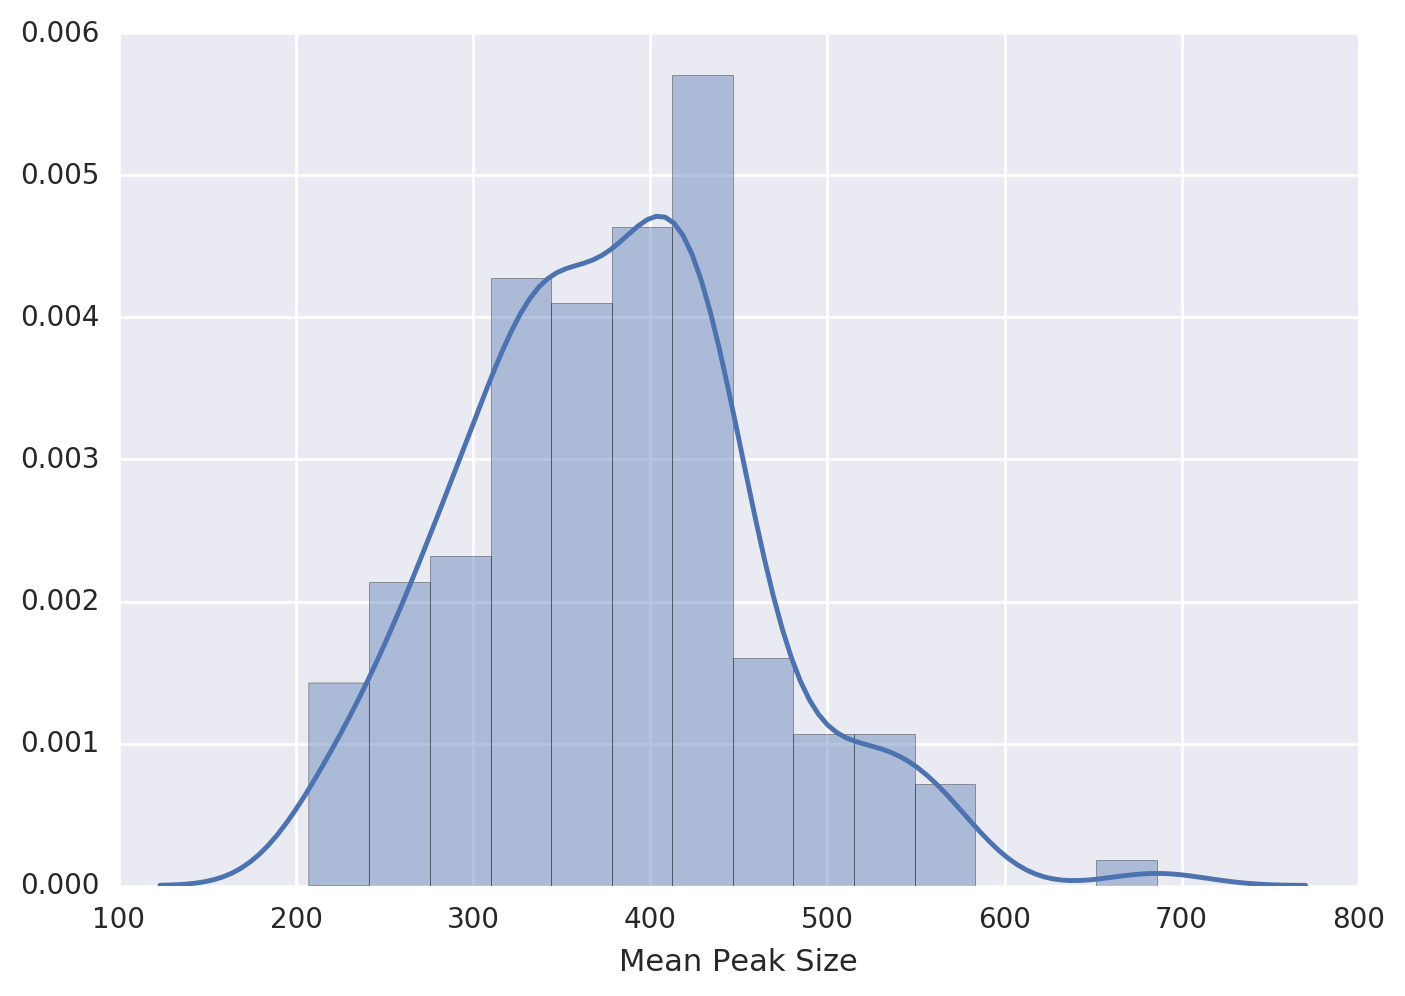

In [11]:
sns.distplot(filtered_metadata_frame['Mean Peak Size'])

In [ ]:
peak_size = 200
if not os.path.isdir('./resized_peaks/'):
    os.mkdir('./resized_peaks/')
for fn in filtered_metadata_frame['File Name'].values:
    peak_frame = pd.read_csv('./idr_peaks/' + fn, sep='\t', names = ['chrom',
                                                                     'chromStart',
                                                                     'chromEnd',
                                                                     'name',
                                                                     'score',
                                                                     'strand',
                                                                     'signalValue',
                                                                     'pValue',
                                                                     'qValue',
                                                                     'peak'])
    peak_sizes = peak_frame['chromEnd'] - peak_frame['chromStart']
    centers = peak_frame['chromStart'] + (peak_sizes/2)
    new_starts = centers - peak_size/2
    new_ends = centers + peak_size/2
    peak_frame['chromStart'] = new_starts.astype(int)
    peak_frame['chromEnd'] = new_ends.astype(int)
    peak_frame.to_csv('./resized_peaks/' + fn, sep='\t', index=False, header=False)


### Filter away random peaks

In [151]:
peak_size = 200
if not os.path.isdir('./filtered_peaks/'):
    os.mkdir('./filtered_peaks/')
for fn in filtered_metadata_frame['File Name'].values:
    peak_frame = pd.read_csv('./resized_peaks/' + fn, sep='\t', names = ['chrom',
                                                                     'chromStart',
                                                                     'chromEnd',
                                                                     'name',
                                                                     'score',
                                                                     'strand',
                                                                     'signalValue',
                                                                     'pValue',
                                                                     'qValue',
                                                                     'peak'])
    peak_frame = peak_frame[(~peak_frame['chrom'].str.contains('random')) &
                            (~peak_frame['chrom'].str.contains('chrUn')) &
                            (~peak_frame['chrom'].str.contains('alt')) &
                            (~peak_frame['chrom'].str.contains('chrY')) &
                            (~peak_frame['chrom'].str.contains('chrM')) &
                            (~peak_frame['chrom'].str.contains('chrEBV'))]
    peak_frame.to_csv('./filtered_peaks/' + fn, sep='\t', index=False, header=False)


## De novo motif analysis

In [ ]:
if not os.path.isdir('./denovo_motif_analysis'):
    os.mkdir('./denovo_motif_analysis')
for peak_file in os.listdir('./filtered_peaks/'):
    output_directory = './denovo_motif_analysis/' + '_'.join(peak_file.split('_')[:-1])
    print('findMotifsGenome.pl ./filtered_peaks/' +peak_file + ' hg38 ' + output_directory + ' -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif')
    os.system('findMotifsGenome.pl ./filtered_peaks/' +peak_file + ' hg38 ' + output_directory + ' -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif')

findMotifsGenome.pl ./resized_peaks/NR2F6-human_1_ENCFF194VBK.bed hg38 ./denovo_motif_analysis/NR2F6-human_1 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/LEF1-human_1_ENCFF134HQP.bed hg38 ./denovo_motif_analysis/LEF1-human_1 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/IKZF1-human_2_ENCFF785BTP.bed hg38 ./denovo_motif_analysis/IKZF1-human_2 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/CREM-human_1_ENCFF021XJN.bed hg38 ./denovo_motif_analysis/CREM-human_1 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/CEBPB-human_1_ENCFF321KQD.bed hg38 ./denovo_motif_analysis/CEBPB-human_1 -size 200 -S 5 -p 8 -noknown -mcheck ./all_threshold_0.25.motif
findMotifsGenome.pl ./resized_peaks/RUNX1-human_2_ENCFF545WXN.bed hg38 ./denovo_motif_analysis/RUNX1-human_2 -size 200 -S 5 -p 8 -noknown -

In [ ]:
%%bash
# move motifs
for i in ./denovo_motif_analysis/*/; do echo $i; motif=${i#./*/}; motif=${motif%/}; cp $i/homerResults/motif1.motif ./motifs/${motif}.txt ;done

## Jaspar Motif Download

In [ ]:
def readMotifFile(motifPath):
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

In [ ]:
#jaspar 2016 nonredundant vertebrate motifs
! wget http://jaspar.genereg.net/html/DOWNLOAD/JASPAR_CORE/pfm/nonredundant/pfm_vertebrates.txt

In [ ]:
out_dir = './jaspar_motifs/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
with open('./pfm_vertebrates.txt') as f:
    data = f.readlines()
counter = 0
for i in range(0,len(data),6):
    name_line = data[i]
    A_line = data[i+1]
    C_line = data[i+2]
    G_line = data[i+3]
    T_line = data[i+4]
    
    A_freqs = np.array([float(x) for x in A_line[4:-3].split()])
    C_freqs = np.array([float(x) for x in C_line[4:-3].split()])
    G_freqs = np.array([float(x) for x in G_line[4:-3].split()])
    T_freqs = np.array([float(x) for x in T_line[4:-3].split()])
    
    freqs = np.array([A_freqs, C_freqs, G_freqs, T_freqs])
    normed_freqs = freqs/freqs.sum(axis=0)
    normed_freqs = normed_freqs.T
    motif_name = name_line.strip().split()[-1]
    
    out_file = open(out_dir + motif_name + '.txt', 'w')
    out_file.write(name_line)
    for i in range(normed_freqs.shape[0]):
        out_file.write('\t'.join([str(x) for x in normed_freqs[i]]) + '\n')
    out_file.close()
    

## Extract Sequences Under Peaks

In [ ]:
%%bash
rm ./sequences/*
for i in ./filtered_peaks/*bed;
do output=${i/.bed/.txt};
output=${output/filtered_peaks/sequences};
# echo "homerTools extract $i /home/jtao/software/homer/data/genomes/hg38/ > $output";
homerTools extract $i /home/jtao/software/homer/data/genomes/hg38/ > $output
done

In [145]:
def read_bed_file(input_path):
    '''
    reads a bed file and returns the genomic coordinates
    '''
    with open(input_path) as f:
        data = f.readlines()
    coordinates = []
    for line in data:
        tokens = line.strip().split()
        chrom = tokens[0]
        start = tokens[1]
        end = tokens[2]
        coordinates.append((chrom,start, end))
    return coordinates

In [149]:
def extract_sequence(coordinates, genome, out_file_path):
    '''
    Given a list of genomic coordinates, extracts sequences
    inputs: [(chrom1, start1, end1), ..., (chromN, startN, endN)]
    outputs: [seq1, seq2, ...seqN]
    '''
    if genome == 'mm10':
        genome_path = '/home/jtao/code/tba/' + '/mm10/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' , 
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10', 
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
                        'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
    elif genome == 'hg38':
        genome_path = '/home/jtao/code/tba/' + '/hg38/'
        chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' , 
                        'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10', 
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
                        'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 
                        'chr21', 'chr22', 'chrX']
    chrom_size_dict = {}
    chrom_seq_dict = {}

    print('reading genome', genome)
    for chrom in chromosomes:
        with open(genome_path + chrom + '.fa') as f:
            data = f.readlines()
        seq = ''.join(x.upper().strip() for x in data[1:])
        size = len(seq)
        chrom_size_dict[chrom] = size
        chrom_seq_dict[chrom] = seq 
    
    out_file = open(out_file_path, 'w')
    for coord in coordinates:
        chrom = coord[0]
        # chrom_seq dict is 0 indexed, genome coords are 1 indexed
        start = int(coord[1]) - 1
        end = int(coord[2]) - 1
        seq = chrom_seq_dict[chrom][start:end] 
        id_line = '>' + str(coord[0]) + ':' +str(coord[1]) + '-' + str(coord[2]) + '\n'
        out_file.write(id_line)
        out_file.write(seq + '\n')
    out_file.close()


In [162]:
peak_dir = './filtered_peaks/'
sequence_dir = './sequences_new/'
if not os.path.isdir(sequence_dir):
    os.mkdir(sequence_dir)
counter = 0
for pf in os.listdir(peak_dir):
    coordinates = read_bed_file(peak_dir + '/' + pf)
    output_path = sequence_dir + '/' + pf.replace('.bed','.txt')
    if not os.path.isfile(output_path):
        counter +=1
        extract_sequence(coordinates, 'hg38', output_path)
#         print('/home/jtao/code/tba/extract_sequences.py ' + peak_dir + '/' + pf + ' hg38 '+output_path)

## Construct Background Regions

In [59]:
%%bash
rm ./make_background.sh
script_path="./make_background.sh"
if [ ! -d ./background/ ]; then mkdir ./background; fi
for i in ./filtered_peaks/*bed;
do 
factor=${i##*/};
factor=${factor%_*};
fasta_path="./background/${factor}_background.fasta"
bed_path="./background/${factor}_background.bed"
if [ ! -f $fasta_path ];
then
# echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome hg38";
# echo "mv ./background/background.bed $bed_path";
# echo "mv ./background/background.fasta $fasta_path";
echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome hg38" >> $script_path;
echo "mv ./background/background.bed $bed_path" >> $script_path;
echo "mv ./background/background.fasta $fasta_path" >> $script_path;
fi
done

## Score Motif Similarity and Cluster

### De Novo Motifs

In [82]:
!python /gpfs/data01/glasslab/home/jtao/code/motif_tools/score_motifs.py ./motif_similarity_scores ./motifs/*

Reading motif files...
Calculating alignments between motifs and scoring motifs
Creating visualizations...
Serializing scores... 
correlation should be used for clustering.


In [ ]:
!python /gpfs/data01/glasslab/home/jtao/code/motif_tools/threshold_cluster_motifs.py ./motif_similarity_scores/correlation.npz ./motif_clustering/ 0.8 ./motifs/*

### Jaspar Motifs

In [292]:
!python /gpfs/data01/glasslab/home/jtao/code/motif_tools/score_motifs.py ./jaspar_motif_similarity_scores ./jaspar_motifs/*

Reading motif files...
Calculating alignments between motifs and scoring motifs
Creating visualizations...
Serializing scores... 
correlation should be used for clustering.


In [293]:
!python /gpfs/data01/glasslab/home/jtao/code/motif_tools/threshold_cluster_motifs.py ./jaspar_motif_similarity_scores/correlation.npz ./jaspar_motif_clustering/ 0.8 ./jaspar_motifs/*

sh: -c: line 0: syntax error near unexpected token `('
sh: -c: line 0: `seqlogo -f "0.307169644002901.2.tmp" -F PNG -S -c -o ./jaspar_motif_clustering//html_files/Nr2f6(var.2)_Rarb_merged.motif -h 2 -w 14.25 2> /dev/null'
sh: -c: line 0: syntax error near unexpected token `('
sh: -c: line 0: `seqlogo -f "0.210321198291243.2.tmp" -F PNG -S -c -o ./jaspar_motif_clustering//html_files/Nr2f6(var.2).motif -h 2 -w 13.5 2> /dev/null'
sh: -c: line 0: syntax error near unexpected token `('
sh: -c: line 0: `seqlogo -f "0.280189915866689.2.tmp" -F PNG -S -c -o ./jaspar_motif_clustering//html_files/Creb5_JDP2(var.2)_JUND(var.2)_merged.motif -h 2 -w 13.5 2> /dev/null'
sh: -c: line 0: syntax error near unexpected token `('
sh: -c: line 0: `seqlogo -f "0.788497228714736.2.tmp" -F PNG -S -c -o ./jaspar_motif_clustering//html_files/JUND(var.2).motif -h 2 -w 13.5 2> /dev/null'
sh: -c: line 0: syntax error near unexpected token `('
sh: -c: line 0: `seqlogo -f "0.982256790696741.2.tmp" -F PNG -S -c -o ./j

## Read in Motifs

In [12]:
def read_motif_file(motifPath):
    '''
    reads all motif files in a directory 
    inputs: path to a directory containing homer motif files
    outputs: an array of tuples representing each motif
    '''
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

In [48]:
motif_dir = './motif_similarity_scores/clustered_motifs/'
all_clustered_motifs = []
for m in os.listdir(motif_dir):
    motif = read_motif_file(motif_dir + '/' + m)
    all_clustered_motifs.append(motif)
# sort motifs by name
all_clustered_motifs.sort(key=lambda x:x[0])

In [49]:
motif_dir = './motifs/'
all_motifs = []
for m in os.listdir(motif_dir):
    motif = read_motif_file(motif_dir + '/' + m)
    all_motifs.append(motif)
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


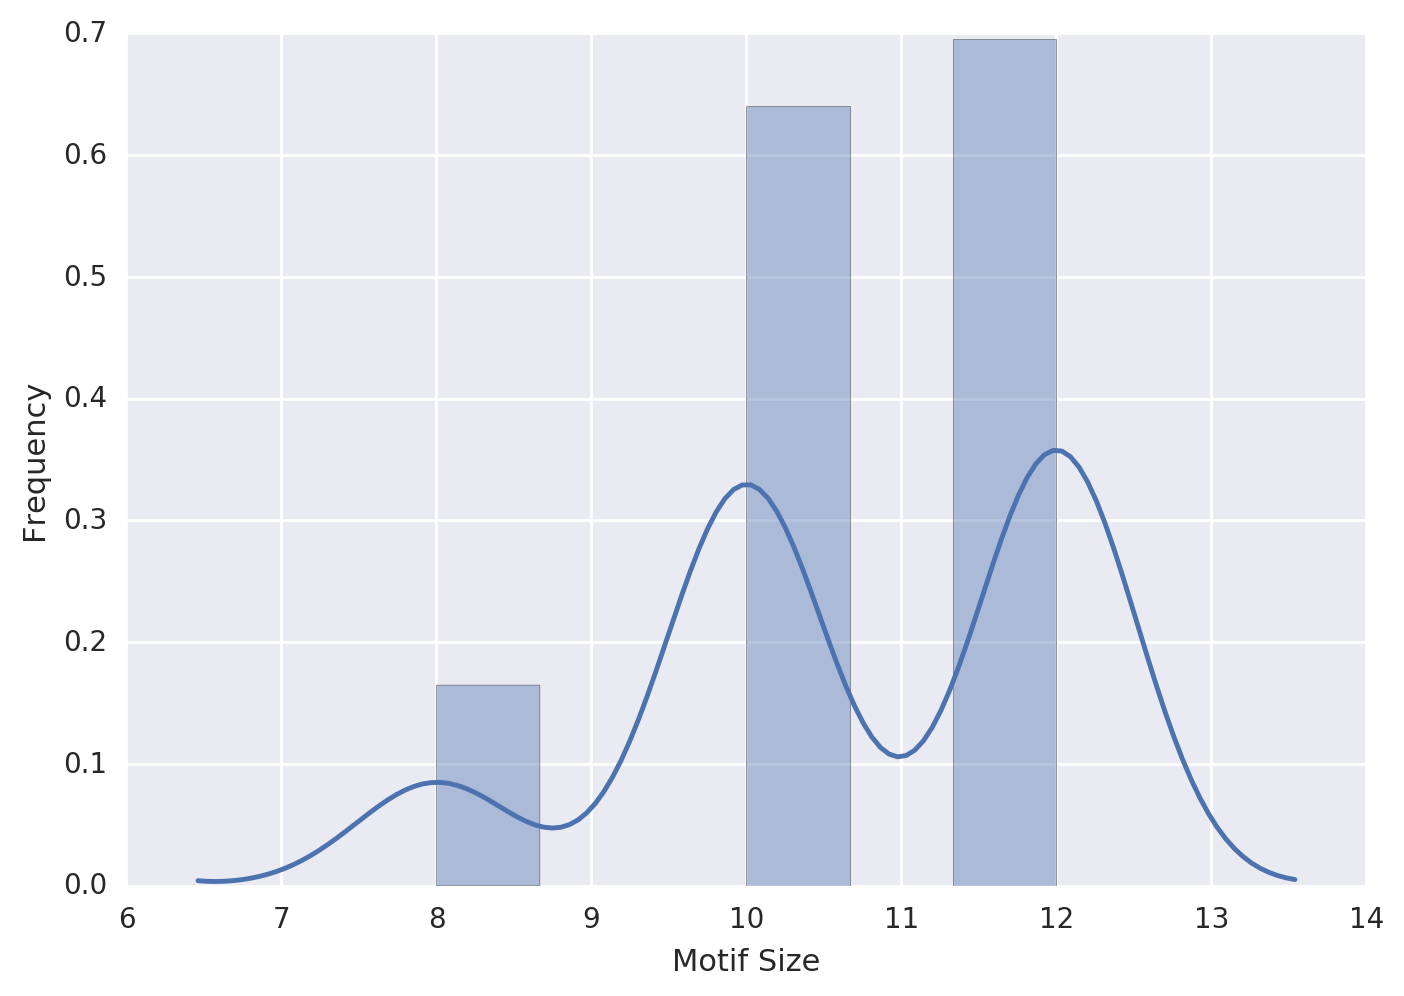

In [14]:
lengths = []
for motif in all_motifs:
    lengths.append(motif[1].shape[0])
sns.distplot(lengths)
plt.xlabel('Motif Size')
plt.ylabel('Frequency')

## Calculate Features

### De novo full

In [ ]:
%%bash
positive_seq_dir="./sequences_new/"
negative_seq_dir="./background/"
out_dir="./tba_output_denovo_full/"
script_path='./calculate_features_denovo_full.sh'
motif_dir='./motifs/'
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for positive_seq_path in $positive_seq_dir/*;
    do factor=${positive_seq_path##./*/};
    factor=${factor%_*};
    negative_seq_path=${negative_seq_dir}/${factor}_background.fasta;
    echo "python /home/jtao/code/tba/create_features.py $positive_seq_path $negative_seq_path $out_dir ${motif_dir}/* -num_proc 28" >>$script_path
    echo "mv $out_dir/labels.txt $out_dir/${factor}_labels.txt" >> $script_path
    echo "mv $out_dir/standardized_features.tsv $out_dir/${factor}_standardized_features.tsv" >> $script_path
done

### De novo clustered

In [ ]:
%%bash
positive_seq_dir="./sequences_new/"
negative_seq_dir="./background/"
out_dir="./tba_output_denovo_clustered/"
script_path='./calculate_features_denovo_clustered.sh'
motif_dir='./motif_clustering/clustered_motifs/'
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for positive_seq_path in $positive_seq_dir/*;
    do factor=${positive_seq_path##./*/};
    factor=${factor%_*};
    negative_seq_path=${negative_seq_dir}/${factor}_background.fasta;
    echo "python /home/jtao/code/tba/create_features.py $positive_seq_path $negative_seq_path $out_dir ${motif_dir}/* -num_proc 28" >>$script_path
    echo "mv $out_dir/labels.txt $out_dir/${factor}_labels.txt" >> $script_path
    echo "mv $out_dir/standardized_features.tsv $out_dir/${factor}_standardized_features.tsv" >> $script_path
done

### Jaspar Full

In [628]:
%%bash
positive_seq_dir="./sequences_new/"
negative_seq_dir="./background/"
out_dir="./tba_output_jaspar_full/"
script_path='./calculate_features_jaspar_full.sh'
motif_dir='./jaspar_motifs/'
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for positive_seq_path in $positive_seq_dir/*;
    do factor=${positive_seq_path##./*/};
    factor=${factor%_*};
    negative_seq_path=${negative_seq_dir}/${factor}_background.fasta;
    echo "python /home/jtao/code/tba/create_features.py $positive_seq_path $negative_seq_path $out_dir ${motif_dir}/* -num_proc 4" >>$script_path
    echo "mv $out_dir/labels.txt $out_dir/${factor}_labels.txt" >> $script_path
    echo "mv $out_dir/standardized_features.tsv $out_dir/${factor}_standardized_features.tsv" >> $script_path
done

### Jaspar Clustered

In [629]:
%%bash
positive_seq_dir="./sequences_new/"
negative_seq_dir="./background/"
out_dir="./tba_output_jaspar_clustered/"
script_path='./calculate_features_jaspar_clustered.sh'
motif_dir='./jaspar_motif_clustering/clustered_motifs/'
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for positive_seq_path in $positive_seq_dir/*;
    do factor=${positive_seq_path##./*/};
    factor=${factor%_*};
    negative_seq_path=${negative_seq_dir}/${factor}_background.fasta;
    echo "python /home/jtao/code/tba/create_features.py $positive_seq_path $negative_seq_path $out_dir ${motif_dir}/* -num_proc 36" >>$script_path
    echo "mv $out_dir/labels.txt $out_dir/${factor}_labels.txt" >> $script_path
    echo "mv $out_dir/standardized_features.tsv $out_dir/${factor}_standardized_features.tsv" >> $script_path
done

## VIF Analysis

In [157]:
def calculateVIF(features):
    '''
    calculates the VIF for each feature
    inputs: features, n X m (numSamples x numFeatures) vector of features
    output: VIFS, list of m VIFS
    '''
    vifs = []
    all_motifs = features.columns.values
    for motif in all_motifs:
        current_motif_scores = features[[motif]]
        other_motif_scores = features[[x for x in all_motifs if not x == motif]]
        lr = sklearn.linear_model.LinearRegression(n_jobs=-1)
        lr.fit(other_motif_scores, current_motif_scores)
        
        # calculate the coefficient of determination
        coeff_det = lr.score(other_motif_scores, current_motif_scores)
        # calculate VIF
        if coeff_det == 1:
            vif = 10
        else:
            vif = 1/(1-coeff_det)
        vifs.append(vif)
    toReturn = pd.Series(data = vifs, index = all_motifs)
    return toReturn

### Full Motif Set

In [227]:
score_dir = './standardized_motif_scores_full/'
vif_dir = './vifs/'
if not os.path.isdir(vif_dir):
    os.mkdir(vif_dir)

# get motif names
sorted_factors = sorted(['_'.join(x.split('_')[:2]) for x in os.listdir(target_score_dir)])

for sd in sorted(os.listdir(score_dir)):
    factor = '_'.join(sd.split('_')[:2])
    out_path = vif_dir + factor + '_vif_full.pickle'
    feature_path = score_dir + factor + '_standardized_motif_scores.pickle'
    if not os.path.isfile(out_path):
        print(factor)
        standardized_combined_frame = pd.read_pickle(feature_path)
        
        # calculate VIFS
        vifs = calculateVIF(standardized_combined_frame)

        # serialize vifs
        pickle.dump(vifs, open(out_path, 'wb'))

ARID1B-human_1
ARNT-human_1
ARNT-human_2
ATF2-human_1
ATF3-human_1
BACH1-human_1
BCLAF1-human_1
BCLAF1-human_2
BCOR-human_1
BHLHE40-human_1
BMI1-human_1
C11orf30-human_1
CBX1-human_1
CBX3-human_1
CBX5-human_1
CDC5L-human_1
CEBPB-human_1
CEBPZ-human_1
CHAMP1-human_1
CREB3L1-human_1
CREM-human_1
CTBP1-human_1
CTCF-human_1
DDX20-human_1
DEAF1-human_1
DNMT1-human_1
DPF2-human_1
E2F1-human_1
ELF1-human_1
ELF4-human_1
ELK1-human_1
EP300-human_1
ESRRA-human_1
ETS1-human_1
ETV6-human_1
ETV6-human_2
FLAG-ATF1-human_1
FLAG-PBX2-human_1
FOSL1-human_1
FOXA1-human_1
FOXK2-human_1
FOXK2-human_2
FOXM1-human_1
GTF2F1-human_1
HCFC1-human_1
HDAC1-human_1
HDAC1-human_2
HDAC2-human_1
HDGF-human_1
HDGF-human_2
HES1-human_1
IKZF1-human_1
IKZF1-human_2
IRF1-human_1
IRF1-human_2
IRF2-human_1
JUNB-human_1
JUND-human_1
KAT8-human_1
KDM1A-human_1
KDM1A-human_2
KDM4B-human_1
KLF16-human_1
L3MBTL2-human_1
LEF1-human_1
MAFF-human_1
MAFK-human_1
MBD2-human_1
MCM3-human_1
MCM7-human_1
MCM7-human_2
MEF2A-human_1
MGA-h

### Clustered Motif Set

In [228]:
score_dir = './standardized_motif_scores_clustered/'
vif_dir = './vifs/'
if not os.path.isdir(vif_dir):
    os.mkdir(vif_dir)

# get motif names
sorted_factors = sorted(['_'.join(x.split('_')[:2]) for x in os.listdir(target_score_dir)])

for sd in sorted(os.listdir(score_dir)):
    factor = '_'.join(sd.split('_')[:2])
    out_path = vif_dir + factor + '_vif_clustered.pickle'
    feature_path = score_dir + factor + '_standardized_motif_scores.pickle'
    if not os.path.isfile(out_path):
        print(factor)
        standardized_combined_frame = pd.read_pickle(feature_path)
        
        # calculate VIFS
        vifs = calculateVIF(standardized_combined_frame)

        # serialize vifs
        pickle.dump(vifs, open(out_path, 'wb'))

ARID1B-human_1
ARNT-human_1
ARNT-human_2
ATF2-human_1
ATF3-human_1
BACH1-human_1
BCLAF1-human_1
BCLAF1-human_2
BCOR-human_1
BHLHE40-human_1
BMI1-human_1
C11orf30-human_1
CBX1-human_1
CBX3-human_1
CBX5-human_1
CDC5L-human_1
CEBPB-human_1
CEBPZ-human_1
CHAMP1-human_1
CREB3L1-human_1
CREM-human_1
CTBP1-human_1
CTCF-human_1
DDX20-human_1
DEAF1-human_1
DNMT1-human_1
DPF2-human_1
E2F1-human_1
ELF1-human_1
ELF4-human_1
ELK1-human_1
EP300-human_1
ESRRA-human_1
ETS1-human_1
ETV6-human_1
ETV6-human_2
FLAG-ATF1-human_1
FLAG-PBX2-human_1
FOSL1-human_1
FOXA1-human_1
FOXK2-human_1
FOXK2-human_2
FOXM1-human_1
GTF2F1-human_1
HCFC1-human_1
HDAC1-human_1
HDAC1-human_2
HDAC2-human_1
HDGF-human_1
HDGF-human_2
HES1-human_1
IKZF1-human_1
IKZF1-human_2
IRF1-human_1
IRF1-human_2
IRF2-human_1
JUNB-human_1
JUND-human_1
KAT8-human_1
KDM1A-human_1
KDM1A-human_2
KDM4B-human_1
KLF16-human_1
L3MBTL2-human_1
LEF1-human_1
MAFF-human_1
MAFK-human_1
MBD2-human_1
MCM3-human_1
MCM7-human_1
MCM7-human_2
MEF2A-human_1
MGA-h

In [342]:
vif_dir = './vifs/'

vif_list = []
type_list = []
motifName_list = []
factor_list = []
factor_vif_full_dict = {}
factor_vif_clustered_dict = {}

clustered_motif_names = None
full_motif_names = None
for v in sorted(os.listdir(vif_dir)):
    tokens = v.split('_')
    factor = '_'.join(tokens[:2])
    vif_type = tokens[3].replace('.pickle','')
    vifs = np.load(vif_dir + v)
    
    names = list(vifs.index.values)
    vals = list(vifs.values)
    
    factor_list = factor_list + [factor] * len(names)
    vif_list = vif_list + vals
    type_list = type_list + [vif_type] * len(names)
    motifName_list = motifName_list + names
    
    if vif_type == 'full':
        if full_motif_names == None:
            full_motif_names = names
        factor_vif_full_dict[factor] = vals
    else:
        if clustered_motif_names == None:
            clustered_motif_names = names
        factor_vif_clustered_dict[factor] = vals

# create data frames
vif_full_frame = pd.DataFrame(factor_vif_full_dict, index = full_motif_names)
vif_clustered_frame = pd.DataFrame(factor_vif_clustered_dict, index = clustered_motif_names)

vif_plotting_frame = pd.DataFrame({'Motif Name': motifName_list,
                         'VIF': vif_list,
                         'Type': type_list,
                         'Factor': factor_list})

In [351]:
bad_vif_clustered = (vif_clustered_frame > 10).sum(axis=0)
concerning_vif_clustered = (vif_clustered_frame > 4).sum(axis=0)

bad_vif_full = (vif_full_frame > 10).sum(axis=0)
concerning_vif_full = (vif_full_frame > 4).sum(axis=0)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


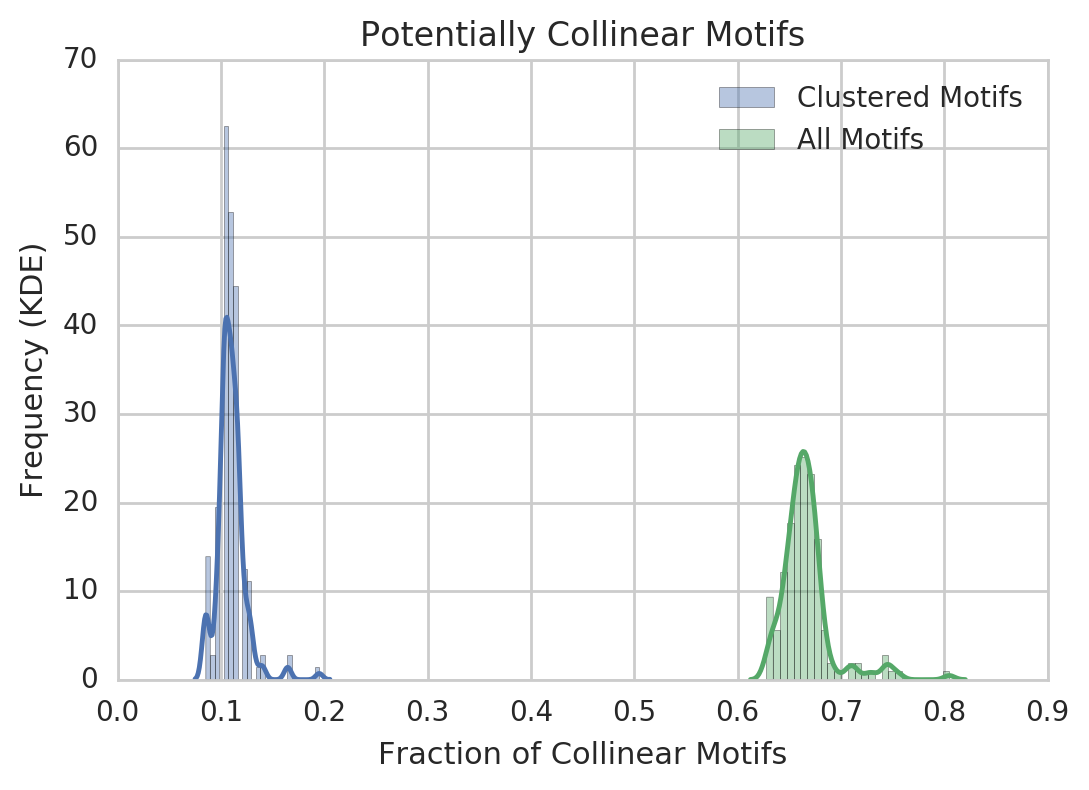

In [659]:
with sns.axes_style('whitegrid'):
    sns.distplot(concerning_vif_clustered/len(concerning_vif_clustered), label='Clustered Motifs')
    sns.distplot(concerning_vif_full/len(concerning_vif_full), label='All Motifs')
    plt.xlabel('Fraction of Collinear Motifs')
    plt.ylabel('Frequency (KDE)')
    plt.title('Potentially Collinear Motifs')
    plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


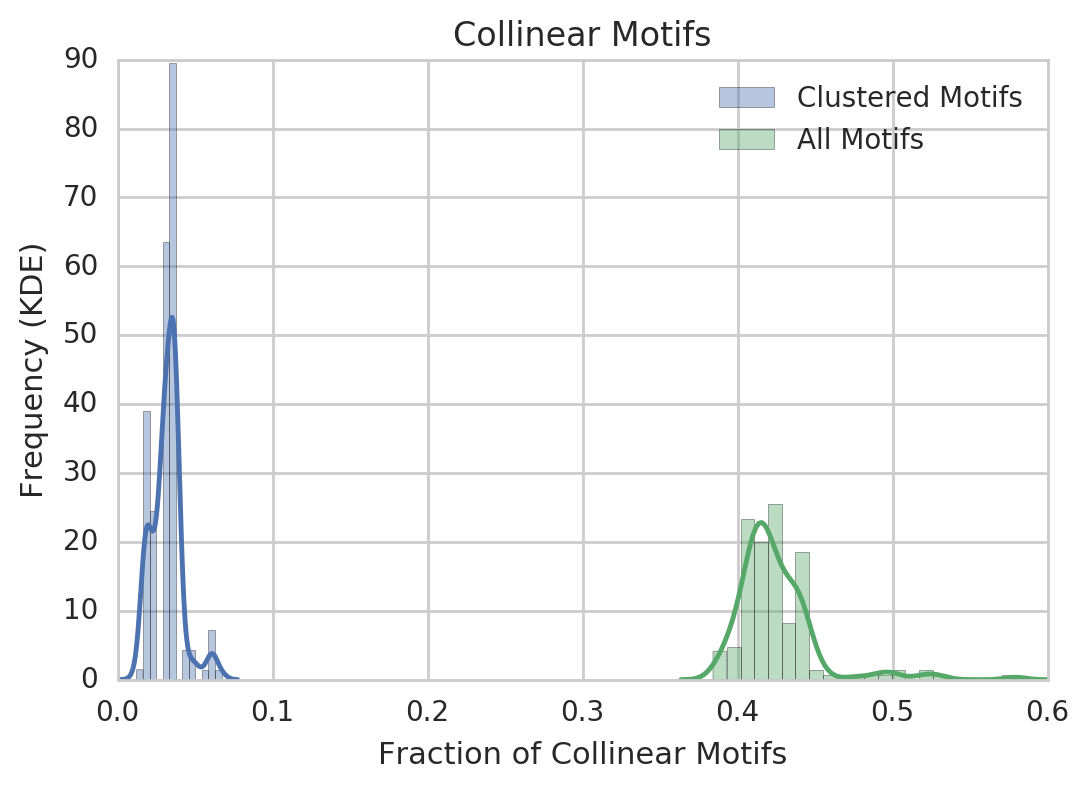

In [660]:
with sns.axes_style('whitegrid'):
    sns.distplot(bad_vif_clustered/len(bad_vif_clustered), label='Clustered Motifs')
    sns.distplot(bad_vif_full/len(bad_vif_full), label='All Motifs')
    plt.xlabel('Fraction of Collinear Motifs')
    plt.ylabel('Frequency (KDE)')
    plt.title('Collinear Motifs')
    plt.legend()
    

## Run Logistic Regression

In [388]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [422]:
def train_classifier(features,
                     labels,
                     numIterations=5,
                     test_size=0.5):
    all_rocs = []
    all_precisions = []
    all_coefficients = []
    all_scores = []
    all_testLabels = []
    start = time.time()
    for i in range(numIterations):  
        iter_start = time.time()
        print('training iteration:', i+1)
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_split(
            features, labels, test_size = test_size)

        #  Train affinity classifier
        classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1, tol=1e-8)
        classifier.fit(training_features, training_labels)

        # score predictions
        probas = classifier.predict_proba(test_features)
        current_rocs = sklearn.metrics.roc_auc_score(test_labels, 
                                                              probas[:, 1], 
                                                              average = None)
        current_precision = sklearn.metrics.average_precision_score(test_labels, 
                                                                             probas[:, 1], 
                                                                             average = None)

         # retrieve coefficients
        current_coefficients = classifier.coef_.flatten()
        
        all_rocs.append(current_rocs)
        all_precisions.append(current_precision)
        all_coefficients.append(current_coefficients)
        all_scores.append(probas)
        all_testLabels.append(test_labels)
        
        iter_end = time.time()
        
        print('iteration training time:', iter_end-iter_start)
    end = time.time()
    
    # convert coefficients into data frame
    all_coefficients = pd.DataFrame(np.array(all_coefficients)).T
    all_coefficients.index = features.columns.values
    print('Total time:', end - start)
    
    results = (all_rocs, 
               all_precisions, 
               all_coefficients,
               all_scores,
               all_testLabels)
    return results
    

In [423]:
def calculate_mean_weights(weights_dict, 
                           sorted_motif_names):
    '''
    '''
    
    factor_coeff_dict = {}

    # calculates the mean of each of the weights
    for factor_treatment in weights_dict.keys():
        current_weights = weights_dict[factor_treatment]
        mean_weights = np.mean(current_weights, axis=0)
        
        factor_coeff_dict[factor_treatment] = mean_weights
    coeff_frame = pd.DataFrame(factor_coeff_dict)
    coeff_frame.index = sorted_motif_names
        
    return coeff_frame

In [424]:
def read_labels(label_path):
    '''
    reads label files created by create_features.py and returns a pandas Series representation
    '''
    indices = []
    vals = []
    with open(label_path) as f:
        data = f.readlines()
    for line in data:
        tokens = line.strip().split()
        indices.append(tokens[0])
        if tokens[1] == '1':
            vals.append(True)
        else:
            vals.append(False)
    to_return = pd.Series(vals, index=indices)
    return to_return

In [429]:
def write_classifier_results(results, output_path):
    '''
    writes results of train_clasifier as tsv files
    '''
    all_rocs = results[0]
    all_precisions = results[1]
    all_coefficients = results[2]
    all_scores = results[3]
    all_test_labels = results[4]
    
    performance_frame = pd.DataFrame({'ROC':all_rocs, 
                                      'Precision Score': all_precisions})
    performance_frame.to_csv(output_path + '/performance.tsv', sep='\t', index=False)
    all_coefficients.to_csv(output_path + '/coefficients.tsv', sep='\t')

    

### Denovo Full

In [442]:
%%bash
feature_dir="./tba_output_denovo_full/"
out_dir="./tba_output_denovo_full/"
script_path='./train_classifier_denovo_full.sh'
iterations="5"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*standardized_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/standardized_features/labels};
    echo "python /home/jtao/code/tba/train_classifier.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/performance.tsv $out_dir/${factor}_performance.tsv" >> $script_path
    echo "mv $out_dir/coefficients.tsv $out_dir/${factor}_coefficients.tsv" >> $script_path
done

### Denovo Clustered

In [441]:
%%bash
feature_dir="./tba_output_denovo_clustered/"
out_dir="./tba_output_denovo_clustered/"
script_path='./train_classifier_denovo_clustered.sh'
iterations="5"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*standardized_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/standardized_features/labels};
    echo "python /home/jtao/code/tba/train_classifier.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/performance.tsv $out_dir/${factor}_performance.tsv" >> $script_path
    echo "mv $out_dir/coefficients.tsv $out_dir/${factor}_coefficients.tsv" >> $script_path
done

### Jaspar Full

In [ ]:
%%bash
feature_dir="./tba_output_jaspar_full/"
out_dir="./tba_output_jaspar_full/"
script_path='./train_classifier_jaspar_full.sh'
iterations="5"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*standardized_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/standardized_features.tsv/labels.txt};
    echo "python /home/jtao/code/tba/train_classifier.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/performance.tsv $out_dir/${factor}_performance.tsv" >> $script_path
    echo "mv $out_dir/coefficients.tsv $out_dir/${factor}_coefficients.tsv" >> $script_path
done

### Jaspar Clustered

In [639]:
%%bash
feature_dir="./tba_output_jaspar_clustered/"
out_dir="./tba_output_jaspar_clustered/"
script_path='./train_classifier_jaspar_clustered.sh'
iterations="1"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*standardized_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/standardized_features.tsv/labels.txt};
    echo "python /home/jtao/code/tba/train_classifier.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/performance.tsv $out_dir/${factor}_performance.tsv" >> $script_path
    echo "mv $out_dir/coefficients.tsv $out_dir/${factor}_coefficients.tsv" >> $script_path
done

## Visualize Performance

### performance of Motif Scores

In [632]:
output_path = './tba_output_denovo_full/'
feature_paths = [x for x in os.listdir(output_path) if 'standardized_features' in x]

factor_pwm_list = []
roc_pwm_list = []
precision_pwm_list = []

for fp in sorted(feature_paths):
    factor = fp.replace('_standardized_features.tsv','')
    print(factor)
    factor_pwm_list.append(factor)
    # motif scores
    features = pd.read_csv(output_path + fp, index_col=0, sep='\t')
    motif_scores = features[factor]
    
    label_path = output_path + '/' + fp.replace('standardized_features', 'labels')
    labels = read_labels(label_path)
    
    roc_pwm = sklearn.metrics.roc_auc_score(labels, motif_scores)
    precision_pwm = sklearn.metrics.roc_auc_score(labels, motif_scores)
    roc_pwm_list.append(roc_pwm)
    precision_pwm_list.append(precision_pwm)   
    

ARID1B-human_1
ARNT-human_1
ARNT-human_2
ATF2-human_1
ATF3-human_1
BACH1-human_1
BCLAF1-human_1
BCLAF1-human_2
BCOR-human_1
BHLHE40-human_1
BMI1-human_1
C11orf30-human_1
CBX1-human_1
CBX3-human_1
CBX5-human_1
CDC5L-human_1
CEBPB-human_1
CEBPZ-human_1
CHAMP1-human_1
CREB3L1-human_1
CREM-human_1
CTBP1-human_1
CTCF-human_1
DDX20-human_1
DEAF1-human_1
DNMT1-human_1
DPF2-human_1
E2F1-human_1
ELF1-human_1
ELF4-human_1
ELK1-human_1
EP300-human_1
ESRRA-human_1
ETS1-human_1
ETV6-human_1
ETV6-human_2
FLAG-ATF1-human_1
FLAG-PBX2-human_1
FOSL1-human_1
FOXA1-human_1
FOXK2-human_1
FOXK2-human_2
FOXM1-human_1
GTF2F1-human_1
HCFC1-human_1
HDAC1-human_1
HDAC1-human_2
HDAC2-human_1
HDGF-human_1
HDGF-human_2
HES1-human_1
IKZF1-human_1
IKZF1-human_2
IRF1-human_1
IRF1-human_2
IRF2-human_1
JUNB-human_1
JUND-human_1
KAT8-human_1
KDM1A-human_1
KDM1A-human_2
KDM4B-human_1
KLF16-human_1
L3MBTL2-human_1
LEF1-human_1
MAFF-human_1
MAFK-human_1
MBD2-human_1
MCM3-human_1
MCM7-human_1
MCM7-human_2
MEF2A-human_1
MGA-h

In [661]:
output_path = './tba_output_denovo_full/'
feature_paths = [x for x in os.listdir(output_path) if 'standardized_features' in x]

factor_list = []
roc_denovo_clustered_list = []
precision_denovo_clustered_list = []
roc_denovo_full_list = []
precision_denovo_full_list = []
roc_jaspar_clustered_list = []
precision_jaspar_clustered_list = []
for fp in sorted(feature_paths):
    factor = fp.replace('_standardized_features.tsv','')
    print(factor)
    factor_list.append(factor)
        
    label_path = output_path + '/' + fp.replace('standardized_features', 'labels')
    labels = read_labels(label_path)
    
    # de novo motifs clustered
    performance_path = './tba_output_denovo_clustered/' + factor + '_performance.tsv'
    performance = pd.read_csv(performance_path, sep='\t')
    means = performance.mean(axis=0)
    roc_denovo_clustered = means['ROC']
    precision_denovo_clustered = means['Precision Score']
    roc_denovo_clustered_list.append(roc_denovo_clustered)
    precision_denovo_clustered_list.append(precision_denovo_clustered)
    
    # de novo motifs full
    performance_path = './tba_output_denovo_full/' + factor + '_performance.tsv'
    performance = pd.read_csv(performance_path, sep='\t')
    means = performance.mean(axis=0)
    roc_denovo_full = means['ROC']
    precision_denovo_full = means['Precision Score']
    roc_denovo_full_list.append(roc_denovo_full)
    precision_denovo_full_list.append(precision_denovo_full)
    
    # jaspar clustered
    performance_path = './tba_output_jaspar_clustered/' + factor + '_performance.tsv'
    performance = pd.read_csv(performance_path, sep='\t')
    means = performance.mean(axis=0)
    roc_jaspar_clustered = means['ROC']
    precision_jaspar_clustered = means['Precision Score']
    roc_jaspar_clustered_list.append(roc_jaspar_clustered)
    precision_jaspar_clustered_list.append(precision_jaspar_clustered)
    
    
    

ARID1B-human_1
ARNT-human_1
ARNT-human_2
ATF2-human_1
ATF3-human_1
BACH1-human_1
BCLAF1-human_1
BCLAF1-human_2
BCOR-human_1
BHLHE40-human_1
BMI1-human_1
C11orf30-human_1
CBX1-human_1
CBX3-human_1
CBX5-human_1
CDC5L-human_1
CEBPB-human_1
CEBPZ-human_1
CHAMP1-human_1
CREB3L1-human_1
CREM-human_1
CTBP1-human_1
CTCF-human_1
DDX20-human_1
DEAF1-human_1
DNMT1-human_1
DPF2-human_1
E2F1-human_1
ELF1-human_1
ELF4-human_1
ELK1-human_1
EP300-human_1
ESRRA-human_1
ETS1-human_1
ETV6-human_1
ETV6-human_2
FLAG-ATF1-human_1
FLAG-PBX2-human_1
FOSL1-human_1
FOXA1-human_1
FOXK2-human_1
FOXK2-human_2
FOXM1-human_1
GTF2F1-human_1
HCFC1-human_1
HDAC1-human_1
HDAC1-human_2
HDAC2-human_1
HDGF-human_1
HDGF-human_2
HES1-human_1
IKZF1-human_1
IKZF1-human_2
IRF1-human_1
IRF1-human_2
IRF2-human_1
JUNB-human_1
JUND-human_1
KAT8-human_1
KDM1A-human_1
KDM1A-human_2
KDM4B-human_1
KLF16-human_1
L3MBTL2-human_1
LEF1-human_1
MAFF-human_1
MAFK-human_1
MBD2-human_1
MCM3-human_1
MCM7-human_1
MCM7-human_2
MEF2A-human_1
MGA-h

In [675]:
performance_frame = pd.DataFrame({'Factor':factor_list,
                                  'ROC PWM': roc_pwm_list,
                                  'Precision PWM':precision_pwm_list,
                                  'ROC Denovo Clustered':roc_denovo_clustered_list,
                                  'Precision Denovo Clustered':precision_denovo_clustered_list,
                                  'ROC Denovo Full':roc_denovo_full_list,
                                  'Precision Denovo Full':precision_denovo_full_list,
                                  'ROC Jaspar Clustered':roc_jaspar_clustered_list,
                                  'Precision Jaspar Clustered':precision_jaspar_clustered_list,
                                 })

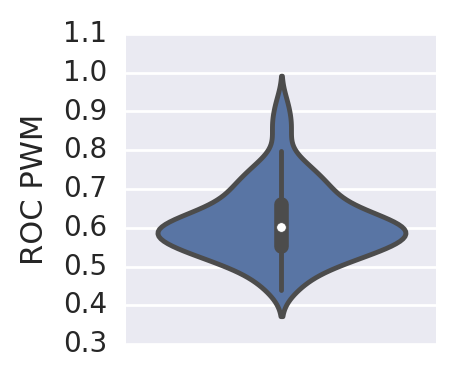

In [697]:
plt.figure(figsize=(2,2))
sns.violinplot(performance_frame['ROC PWM'], orient = 'v')

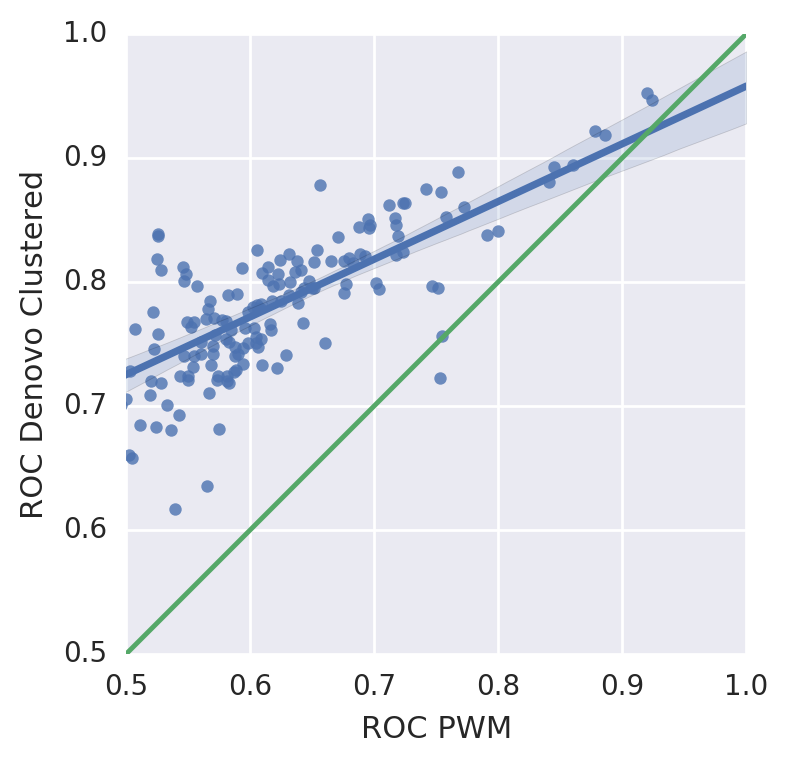

In [676]:
sns.regplot(data = performance_frame, x = 'ROC PWM', y='ROC Denovo Clustered')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.plot([0.5, 1], [0.5,1])
ax = plt.gca()
ax.set_aspect(1)

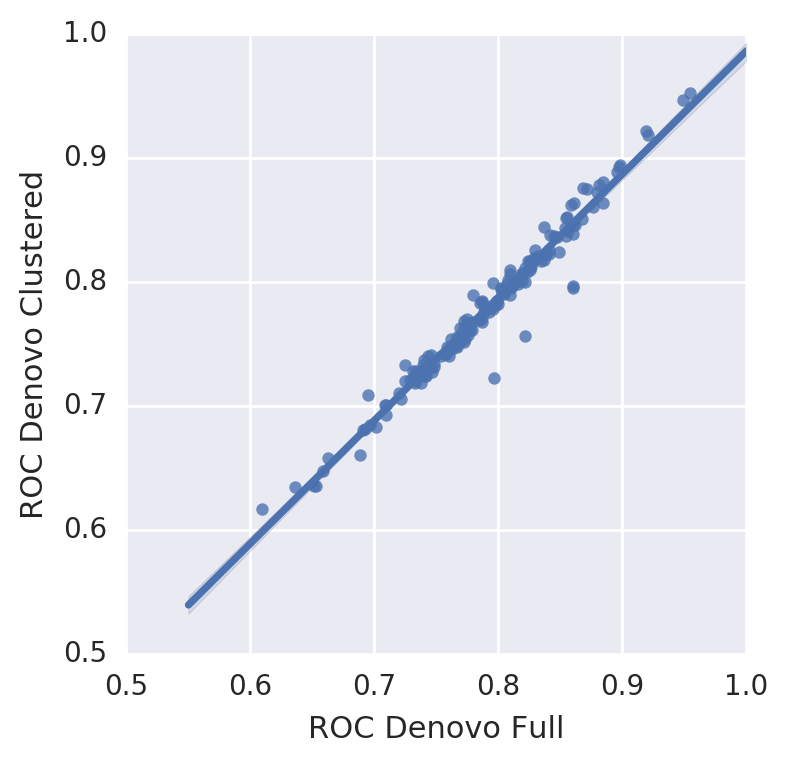

In [724]:
sns.regplot(data = performance_frame, x = 'ROC Denovo Full', y='ROC Denovo Clustered')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
# plt.plot([0.5, 1], [0.5,1])
ax = plt.gca()
ax.set_aspect(1)

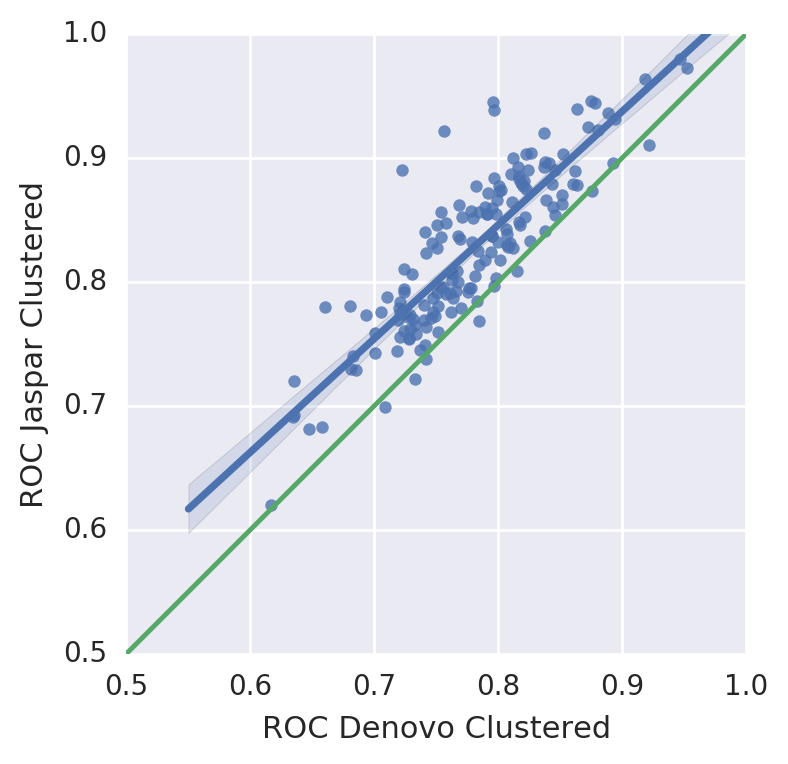

In [678]:
sns.regplot(data = performance_frame, x = 'ROC Denovo Clustered', y='ROC Jaspar Clustered')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.plot([0.5, 1], [0.5,1])
ax = plt.gca()
ax.set_aspect(1)

## Estimate Number of Binding Partners

In [674]:
%%bash
feature_dir="./tba_output_jaspar_clustered/"
out_dir="./tba_output_jaspar_clustered/"
script_path='./estimateNumPartners_classifier_jaspar_clustered.sh'
iterations="1"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*standardized_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/standardized_features.tsv/labels.txt};
    echo "python /home/jtao/code/tba/estimate_num_partners_quick.py  $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/ff_performance.tsv $out_dir/${factor}_ff_performance.tsv" >> $script_path
done

In [701]:
frame = pd.read_csv('./tba_output_jaspar_clustered/ATF3-human_1_ff_performance.tsv', sep='\t')

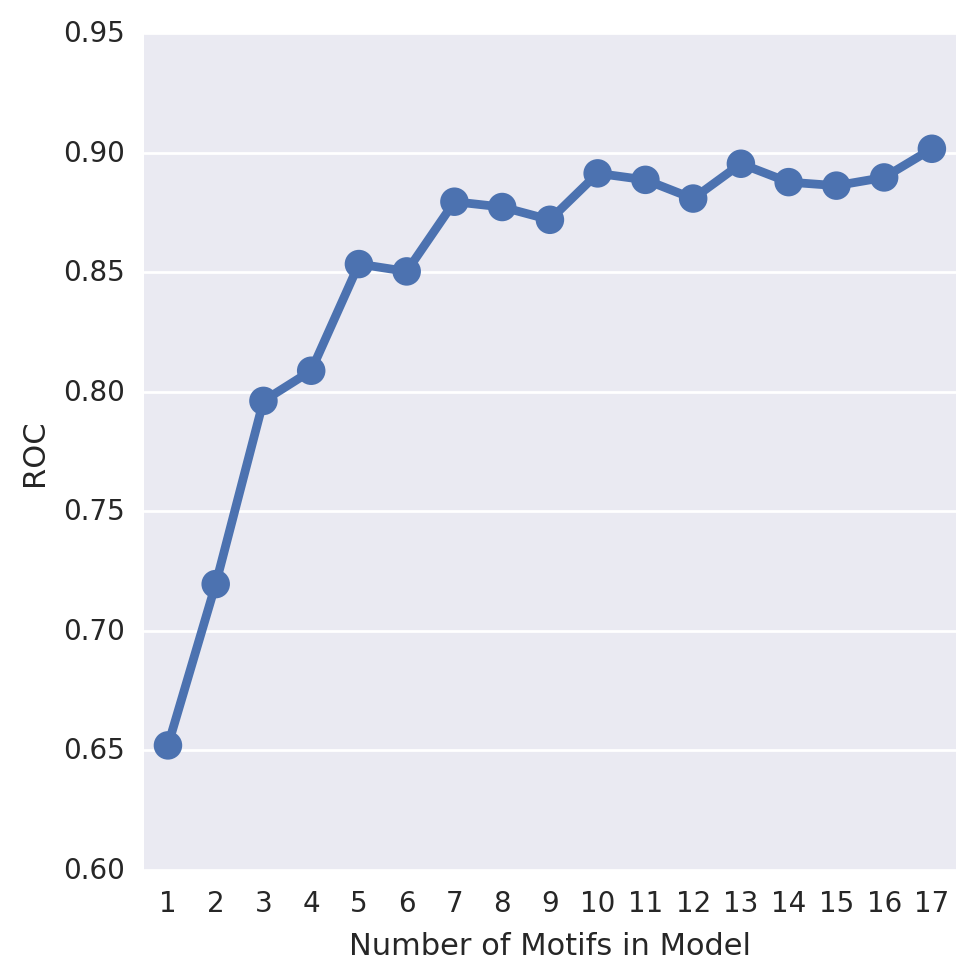

In [706]:
sns.factorplot(data = frame, x='Feature Name', y='ROC', size = 5)
plt.xlabel('Number of Motifs in Model')

In [710]:
len(np.arange(0.85, 0.88, (0.88-0.85)/50))

51

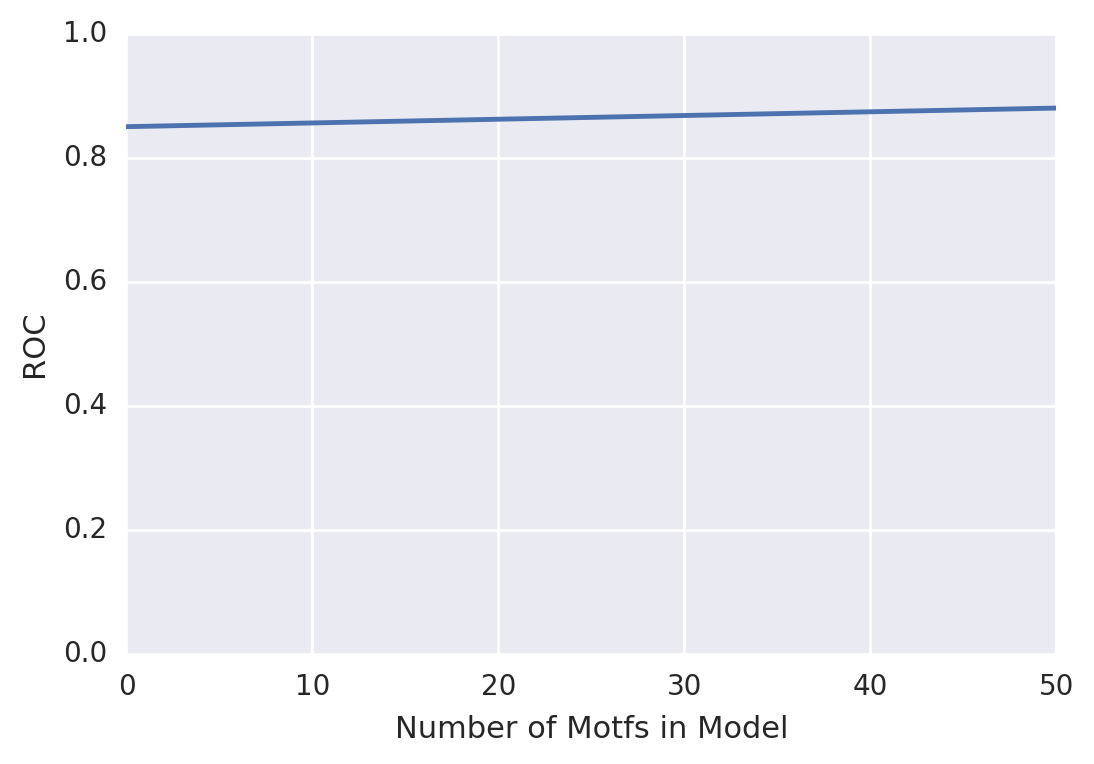

In [712]:
plt.plot(range(51), np.arange(0.85, 0.88, (0.88-0.85)/50))
plt.ylim(0,1)
plt.xlabel('Number of Motfs in Model')
plt.ylabel('ROC')

In [715]:
partners = []
for result in [x for x in os.listdir('./tba_output_jaspar_clustered/') if 'ff_perf' in x ]:
    with open('./tba_output_jaspar_clustered/' + result) as f:
        data = f.readlines()
    num_partners = len(data) - 1
    partners.append(num_partners)

In [718]:
partners = np.array(partners)

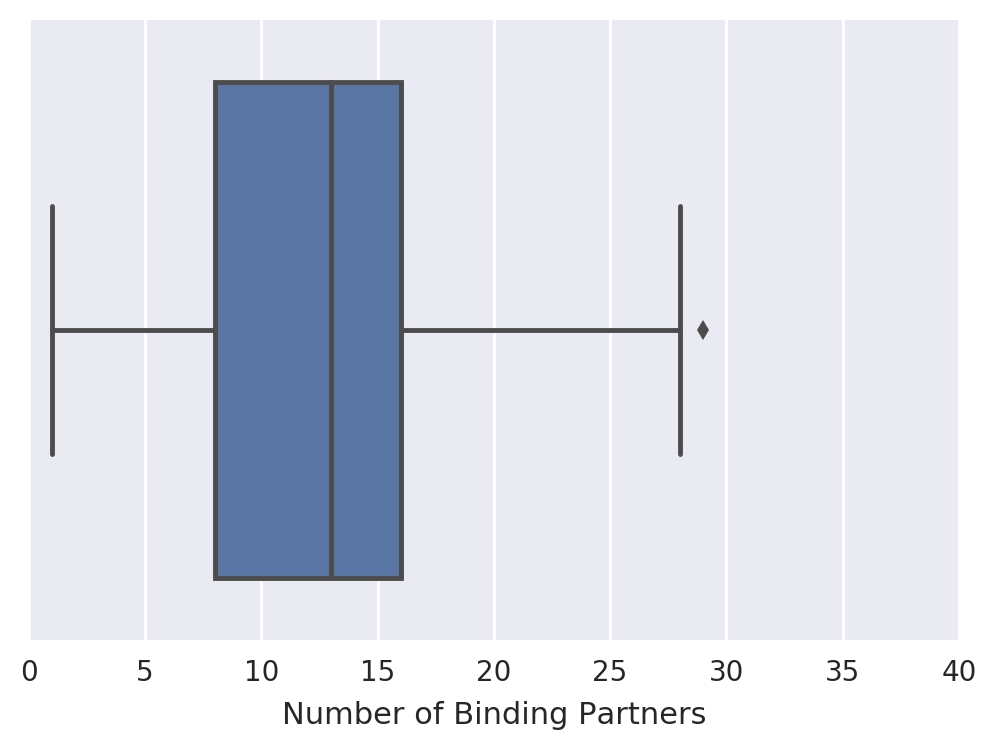

In [723]:
sns.boxplot(partners[partners<30])
plt.xlim(0,40)
plt.xlabel('Number of Binding Partners')

## Calculate TF interaction network

## Calculate Bayesian Markov Models

In [136]:
%%bash
num_proc=8 # number of motifs to calculate at once

if [ ! -d ./bamm_output ]; then mkdir ./bamm_output; fi

script_path="./calculate_bamm.sh"
if [ -f $script_path ]; then rm $script_path; fi
counter=0
for pos_seq in ./sequences_new/*;
    # define output path
    do out_path=${pos_seq/sequences_new/bamm_output};
    out_path=${out_path%_*};

    if [ ! -d $out_path ]; then 
    counter=$[counter + 1]
    

    # find path to negative sequences
    neg_seq=${pos_seq/sequences_new/background};
    neg_seq=${neg_seq%_*}_background.fasta;

    echo BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet >>$script_path;

#         if [ "$counter" -eq "$num_proc" ]; then
#             echo '$('BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet')' >>$script_path;
#         else
#             echo '$('BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet') &' >>$script_path;
#         fi;
        if [ "$counter" -eq "$num_proc" ]; then counter=0; fi
    fi
done


# comparison to fimo scores

In [549]:
def convert_sequences_to_array(seq):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]

    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    seq_array = []
    for nuc in seq:
        seq_array.append(nucleotide_array_dict[nuc])
    seq_array = np.array(seq_array)
    return seq_array

In [576]:
def read_motif_file(motifPath, pseudocount):
    '''
    reads all motif files in a directory
    inputs: path to a directory containing homer motif files
    outputs: an array of tuples representing each motif
    '''
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores = scores + pseudocount
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

In [618]:
def calculate_motif_score(seq,
                          pwm
                          ):
    background_frequency = 0.25

    pwm_length = pwm.shape[0]
    # calculate scores for each motif at each position
    seq_array = convert_sequences_to_array(seq)
    seq_length = seq_array.shape[0]
    scores = []
    for i in range(seq_length - pwm_length + 1):
        # get substring represented as matrix
        subseq_array = seq_array[i: i + pwm_length]
        # get corresponding pwm frequencies
        frequencies = (pwm * subseq_array).sum(axis=1)
        # 0.25 background freq
        ratios = (frequencies)/(background_frequency)
        # calculate log likelihood ratios
        llr = np.log2(ratios)
        # sum to calculate motif score
        score = np.sum(llr)
        scores.append((score, i, '+'))
            
    # calculate reverse complement and scores for reverse complement
    rc_seq_array = seq_array[::-1, ::-1]
    for i in range(seq_length - pwm_length + 1):
        # get substring represented as matrix
        subseq_array = rc_seq_array[i: i + pwm_length]
        # get corresponding pwm frequencies
        frequencies = ((pwm + pseudo_count) * subseq_array).sum(axis=1)
        # 0.25 background freq
        ratios = (frequencies)/(background_frequency)
        # calculate log likelihood ratios
        llr = np.log2(ratios)
        print(llr)
        # sum to calculate motif score
        score = np.sum(llr)
        scores.append((score, seq_length - i, '-'))
    
    scores.sort(key = lambda x:x[0], reverse = True)

    top_hit = scores[0]

    
    return top_hit
    


In [620]:
fimo_frame = pd.read_csv('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/fimo_results/C57BL6J_ap-1.txt', sep='\t')

In [624]:
motif = read_motif_file('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/jaspar_2016_curated_homerFormat/ap-1.motif',
                       0.001)

In [627]:
calculate_motif_score('TGCCTCA', 
                      motif[1],
                     )

[ 1.997129    1.997129    1.997129    0.54290476 -6.96866105  1.93840952
  1.997129  ]


(3.5011692252104138, 7, '-')

In [607]:
fimo_frame.head()

,Motif,Seq,Start,Stop,Log-odds,p-value,Site
ap-1,Merged-chr10-100015739-2,72,78,+,-5.93938,0.009548,GGACTCG
ap-1,Merged-chr10-100030579-1,28,34,-,-1.71115,0.005150,TCACTAA
ap-1,Merged-chr10-100030579-1,32,38,+,3.99205,0.000544,TGAATCA
ap-1,Merged-chr10-100030579-1,32,38,-,9.00693,0.000210,TGATTCA
ap-1,Merged-chr10-100030579-1,165,171,+,3.40206,0.001232,TGCCTCA


In [691]:
frame = pd.read_csv('./tba_output_denovo_full//ATF3-human_1_standardized_features.tsv', sep='\t', index_col=0)

In [692]:
frame.columns

Index(['ARID1B-human_1', 'ARNT-human_1', 'ARNT-human_2', 'ATF2-human_1',
       'ATF3-human_1', 'BACH1-human_1', 'BCLAF1-human_1', 'BCLAF1-human_2',
       'BCOR-human_1', 'BHLHE40-human_1',
       ...
       'ZNF24-human_2', 'ZNF24-human_3', 'ZNF316-human_1', 'ZNF316-human_2',
       'ZNF318-human_1', 'ZNF318-human_2', 'ZNF384-human_1', 'ZNF407-human_1',
       'ZSCAN29-human_1', 'ZZZ3-human_1'],
      dtype='object', length=164)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


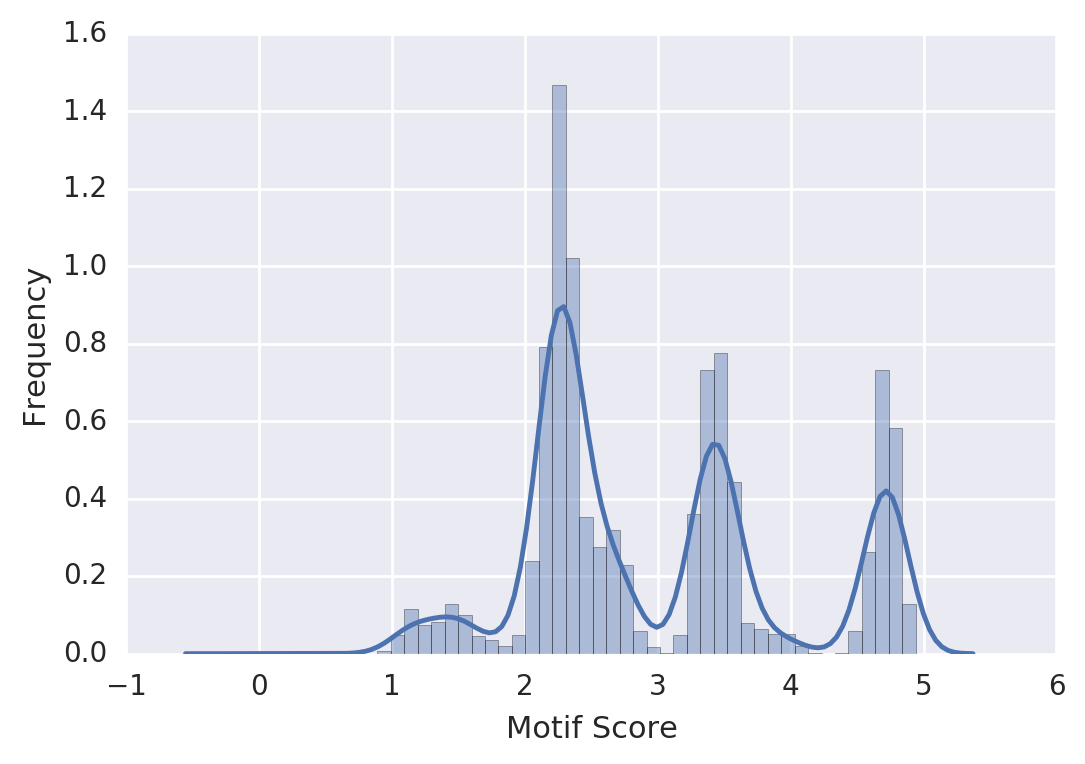

In [696]:
sns.distplot(frame['ATF3-human_1']+3)
plt.xlabel('Motif Score')
plt.ylabel('Frequency')

In [ ]:
plot 